This notebook contains an analysis of the synthetic data provided by Lighthouse Reports
(https://github.com/Lighthouse-Reports/suspicion_machine/tree/main
).

Using their data-generation notebook, I produced the input data used in these experiments.
In addition, I executed their accompanying R script on this synthetic dataset, which applies the original model used by the municipality of Rotterdam. This script adds two new columns, 'Ja' and 'Nee', which are complements of each other and represent the model’s predicted risk scores. 

The R script loads and applies the actual Rotterdam model, stored in caret format at
data/01_raw/20220929_finale_model.rds. This script also performs some tests on the output, which I will use to compare to the results of this study. For example, running the script for the variable 'persoon_geslacht_vrouw' results in the following tables, showing no significant different in predictions for men and women:

In [34]:
import pandas as pd

df = pd.read_csv("C:/Users/jetve/Documents/suspicion_machine/results/statistical_parity/archetypes/persoon_geslacht_vrouw/sum_stats.csv")
df.head(2)


,Unnamed: 0,IV,variable,n,mean,sd,share_above_td_threshold,share_above_rw_threshold,perc_misrep_td_threshold,perc_misrep_rw_threshold,data_type
0,1,IV: \r\npersoon_geslacht_vrouw: 0\r\n,Ja,6542,0.611,0.086,0.101345,0.633293,0.134515,53.329257,synth
1,2,IV: \r\npersoon_geslacht_vrouw: 1\r\n,Ja,6103,0.613,0.084,0.098640,0.649844,-0.135999,54.984434,synth


In [35]:
import pandas as pd

df = pd.read_csv("C:/Users/jetve/Documents/suspicion_machine/results/statistical_parity/archetypes/persoon_geslacht_vrouw/t_test.csv")
df

,Unnamed: 0,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif,data_type
0,1,Ja,IV: \r\npersoon_geslacht_vrouw: 0\r\n,IV: \r\npersoon_geslacht_vrouw: 1\r\n,6542,6103,6.640000e-02,ns,6.640000e-02,ns,synth
1,2,Ja,IV: \r\npersoon_geslacht_vrouw: 0\r\n,IV: \r\npersoon_geslacht_vrouw: 1\r\n,12508,12508,1.000000e-07,****,1.000000e-07,****,synth_conditional


The generated data also contains rows for counterfactual experiments, which I exclude here

In [36]:
df = pd.read_csv("20251023_jv_persoon_geslacht_vrouw.csv")
df_synth = df[df['data_type']=="synth"]

Since the AIF metrics I use work with a binary score, we should translate the risk score to a binary variable. We do this using a threshold. Lighthouse has defined this as 0.7125668 for the synthetic data, in order for 10% of cases to be above the threshold.

In [37]:
# add binary prediction variable
threshold = 0.7125668 
df_synth['binary_pred']= (df_synth['Ja']> threshold).astype(int)

# check if the threshold actually gives 10% above the threshold
print((df_synth["Ja"] > 0.7125668).mean())

df_synth.head()

0.10003954132068012


C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\14759624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_synth['binary_pred']= (df_synth['Ja']> threshold).astype(int)


,"relatie""""",adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,...,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,data_type,Ja,Nee,binary_pred
0,1,6,3,1,0,1012,1,0,0,1,...,0,0,0,0,0,0,synth,0.600234,0.399766,0
1,2,4,2,1,0,5268,1,0,0,0,...,0,1,0,1,0,0,synth,0.748566,0.251434,1
2,3,4,2,0,1,1820,1,0,0,1,...,0,0,0,0,0,0,synth,0.781536,0.218464,1
3,4,3,2,0,1,9056,1,0,0,0,...,0,1,0,0,0,0,synth,0.613350,0.386650,0
4,5,3,3,0,2,5246,1,0,0,1,...,0,1,0,0,0,0,synth,0.688989,0.311011,0


Here we investigate which features have the highest relative importance. This is relevant to know for deciding later on which features to test and investigate. 

In [38]:
import pandas as pd

df = pd.read_csv("features.csv", encoding="latin-1")

df_sorted = df.sort_values("relative_importance", ascending=False)

top20 = df_sorted.head(20)

for i, row in top20.iterrows():
    print(f"{row['feature']}: {row['relative_importance']:.4f}")


persoon_leeftijd_bij_onderzoek: 100.0000
relatie_overig_actueel_vorm__kostendeler: 35.4857
contacten_onderwerp_no_show: 27.8748
competentie_vakdeskundigheid_toepassen: 25.1066
contacten_onderwerp_overleg_met_inkomen: 24.1014
adres_dagen_op_adres: 23.3291
relatie_overig_kostendeler: 20.7489
pla_historie_ontwikkeling: 19.1113
instrument_ladder_huidig_activering: 17.5048
contacten_soort_afgelopenjaar_document__uitgaand_: 15.4138
persoonlijke_eigenschappen_dagen_sinds_taaleis: 15.1538
persoonlijke_eigenschappen_dagen_sinds_opvoer: 14.9285
ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden: 13.8170
relatie_partner_totaal_dagen_partner: 12.4425
pla_hist_pla_categorie_doelstelling_16: 11.9347
relatie_kind_leeftijd_verschil_ouder_eerste_kind: 11.1659
relatie_kind_huidige_aantal: 10.8480
instrument_ladder_historie_activering: 10.7604
persoon_geslacht_vrouw: 9.9040
afspraak_inspanningsperiode: 9.3556


Now we filter the dataset to retain only the variables that will be used in the analysis. I include features that:
- have high relative importance in the model, OR
- are explicitly used in the Lighthouse Reports analysis, because they are considered sensitive attributes, OR
- are clearly relevant in the context of potential sensitive treatment, for example because they may act as proxies for protected characteristics, or because they are substantively meaningful in assessing fairness from an intersectional perspective, AND

-  are interpretable in a reliable way — i.e., variables for which I understand what the numerical values represent. Variables whose meaning or coding is unclear are excluded to avoid incorrect interpretation.

In [39]:

df_aif = df_synth[["adres_aantal_verschillende_wijken","adres_recentste_plaats_other", "adres_recentste_plaats_rotterdam",
                   "adres_recentste_buurt_other","adres_recentste_wijk_delfshaven","contacten_onderwerp_boolean_no_show", 
                   "contacten_onderwerp_boolean_taaleis___voldoet","contacten_onderwerp_boolean_ziek__of_afmelding","beschikbaarheid_huidig_afwijkend_wegens_medische_omstandigheden", 
                   "beschikbaarheid_recent_afwijkend_wegens_medische_omstandigheden","beschikbaarheid_recent_afwijkend_wegens_sociaal_maatschappelijke_situatie",
                   "beschikbaarheid_aantal_historie_afwijkend_wegens_medische_omstandigheden","beschikbaarheid_aantal_historie_afwijkend_wegens_sociaal_maatschappelijke_situatie",
                   "relatie_partner_huidige_partner___partner__gehuwd_", "relatie_partner_totaal_dagen_partner",
                    "belemmering_financiele_problemen", "belemmering_niet_computervaardig","belemmering_psychische_problemen",
                    "belemmering_dagen_financiele_problemen","belemmering_dagen_lichamelijke_problematiek",
                    "belemmering_dagen_psychische_problemen", "typering_hist_inburgeringsbehoeftig","persoon_leeftijd_bij_onderzoek", "persoon_geslacht_vrouw",
                    "persoonlijke_eigenschappen_spreektaal","persoonlijke_eigenschappen_taaleis_schrijfv_ok","persoonlijke_eigenschappen_dagen_sinds_taaleis",
                    "persoonlijke_eigenschappen_nl_spreken1", "persoonlijke_eigenschappen_nl_spreken2", "persoonlijke_eigenschappen_nl_spreken3", "persoonlijke_eigenschappen_nl_lezen3",
                    "persoonlijke_eigenschappen_nl_lezen4", "persoonlijke_eigenschappen_nl_schrijven0","persoonlijke_eigenschappen_nl_schrijven1","persoonlijke_eigenschappen_nl_schrijven2",
                    "persoonlijke_eigenschappen_nl_schrijven3","persoonlijke_eigenschappen_nl_begrijpen3", "relatie_kind_huidige_aantal", 
                    "relatie_kind_heeft_kinderen", "relatie_kind_basisschool_kind", "relatie_kind_jongvolwassen", "relatie_kind_tiener", "relatie_kind_volwassen",
                    "relatie_overig_historie_vorm__andere_inwonende","persoonlijke_eigenschappen_uitstroom_verw_vlgs_km","relatie_kind_leeftijd_verschil_ouder_eerste_kind",
                    "belemmering_hist_taal",
                    'persoonlijke_eigenschappen_spreektaal_anders', "relatie_overig_actueel_vorm__kostendeler",
                    "contacten_onderwerp_no_show",
                    "competentie_vakdeskundigheid_toepassen",
                    "contacten_onderwerp_overleg_met_inkomen",
                    "adres_dagen_op_adres",
                    "relatie_overig_kostendeler",
                    "pla_historie_ontwikkeling",
                    "instrument_ladder_huidig_activering",
                    "contacten_soort_afgelopenjaar_document__uitgaand_",
                    "persoonlijke_eigenschappen_dagen_sinds_opvoer",
                    "ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden",
                    "pla_hist_pla_categorie_doelstelling_16",
                    "instrument_ladder_historie_activering",
                    "afspraak_inspanningsperiode", "belemmering_hist_lichamelijke_problematiek",
                      "Ja", "binary_pred"]]
df_aif.head()


,adres_aantal_verschillende_wijken,adres_recentste_plaats_other,adres_recentste_plaats_rotterdam,adres_recentste_buurt_other,adres_recentste_wijk_delfshaven,contacten_onderwerp_boolean_no_show,contacten_onderwerp_boolean_taaleis___voldoet,contacten_onderwerp_boolean_ziek__of_afmelding,beschikbaarheid_huidig_afwijkend_wegens_medische_omstandigheden,beschikbaarheid_recent_afwijkend_wegens_medische_omstandigheden,...,instrument_ladder_huidig_activering,contacten_soort_afgelopenjaar_document__uitgaand_,persoonlijke_eigenschappen_dagen_sinds_opvoer,ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden,pla_hist_pla_categorie_doelstelling_16,instrument_ladder_historie_activering,afspraak_inspanningsperiode,belemmering_hist_lichamelijke_problematiek,Ja,binary_pred
0,3,0,1,1,1,0,0,1,0,0,...,1,3,442,1125,1,1,1,1,0.600234,0
1,2,0,1,0,0,0,0,1,0,1,...,0,10,11,1718,0,2,1,1,0.748566,1
2,2,0,1,1,0,0,1,1,0,0,...,0,7,188,1740,0,1,1,0,0.781536,1
3,2,0,1,0,0,1,0,0,0,0,...,1,3,741,1199,1,2,1,0,0.613350,0
4,3,0,1,1,0,0,0,1,0,1,...,0,6,225,929,1,3,1,2,0.688989,0


# Statistical parity difference
Now I load the dataset as a standard dataset in AIF. 

First, I will calculate statistical parity for the most important sensitive attributes. These should be marked as protected attributes.
For these, I include:
- gender
- language
- children
- age
- neighbourbood
- financial struggles
- mental struggles
- physical struggles

I have to transform age to a categorical variable: young > 0/1

In [40]:
df_aif["jong"] = (df_aif["persoon_leeftijd_bij_onderzoek"] < 50).astype(int)

df_aif[["jong", "persoon_leeftijd_bij_onderzoek"]].head()

C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\3928240459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aif["jong"] = (df_aif["persoon_leeftijd_bij_onderzoek"] < 50).astype(int)


,jong,persoon_leeftijd_bij_onderzoek
0,0,59
1,1,43
2,1,48
3,0,58
4,0,52


In [ ]:
from aif360.datasets import StandardDataset

protected_attributes = ['persoon_geslacht_vrouw', "contacten_onderwerp_boolean_taaleis___voldoet", 
                        # "persoonlijke_eigenschappen_spreektaal", not interpretable
                        "persoonlijke_eigenschappen_taaleis_schrijfv_ok",
                        # "persoonlijke_eigenschappen_dagen_sinds_taaleis" ,categorical
                        "persoonlijke_eigenschappen_nl_spreken1", "persoonlijke_eigenschappen_nl_spreken2", 
                        "persoonlijke_eigenschappen_nl_spreken3", "persoonlijke_eigenschappen_nl_lezen3",
                        "persoonlijke_eigenschappen_nl_lezen4", "persoonlijke_eigenschappen_nl_schrijven0",
                        "persoonlijke_eigenschappen_nl_schrijven1","persoonlijke_eigenschappen_nl_schrijven2",
                        "persoonlijke_eigenschappen_nl_schrijven3","persoonlijke_eigenschappen_nl_begrijpen3",
                        # "relatie_kind_huidige_aantal", catgeorisch
                        "relatie_kind_heeft_kinderen", 
                        # "relatie_kind_basisschool_kind", "relatie_kind_jongvolwassen", "relatie_kind_tiener", "relatie_kind_volwassen",]
                           "jong", "adres_recentste_wijk_delfshaven", "belemmering_financiele_problemen", 
                            "belemmering_hist_lichamelijke_problematiek"]

dataset_orig = StandardDataset(df=df_aif.copy(),
                               label_name='binary_pred',
                               favorable_classes=[0], # 1 means high risk
                               protected_attribute_names=protected_attributes,
                               privileged_classes=[[0],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[0],[0], [0]]) 


In [72]:
groups = {
    "gender": {
        "priv": [{'persoon_geslacht_vrouw': 0}],
        "unpriv": [{'persoon_geslacht_vrouw': 1}]
    },

    "taaleis": {
        "priv": [{"contacten_onderwerp_boolean_taaleis___voldoet": 1}],
        "unpriv": [{"contacten_onderwerp_boolean_taaleis___voldoet": 0}]
    },

    "taaleis_schrijfv_ok": {
        "priv": [{"persoonlijke_eigenschappen_taaleis_schrijfv_ok": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_taaleis_schrijfv_ok": 0}]
    },

    "nl_spreken1": {
        "priv": [{"persoonlijke_eigenschappen_nl_spreken1": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_nl_spreken1": 0}]
    },
    "nl_spreken2": {
        "priv": [{"persoonlijke_eigenschappen_nl_spreken2": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_nl_spreken2": 0}]
    },
    "nl_spreken3": {
        "priv": [{"persoonlijke_eigenschappen_nl_spreken3": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_nl_spreken3": 0}]
    },

    "nl_lezen3": {
        "priv": [{"persoonlijke_eigenschappen_nl_lezen3": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_nl_lezen3": 0}]
    },
    "nl_lezen4": {
        "priv": [{"persoonlijke_eigenschappen_nl_lezen4": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_nl_lezen4": 0}]
    },

    "nl_schrijven0": {
        "priv": [{"persoonlijke_eigenschappen_nl_schrijven0": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_nl_schrijven0": 0}]
    },
    "nl_schrijven1": {
        "priv": [{"persoonlijke_eigenschappen_nl_schrijven1": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_nl_schrijven1": 0}]
    },
    "nl_schrijven2": {
        "priv": [{"persoonlijke_eigenschappen_nl_schrijven2": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_nl_schrijven2": 0}]
    },
    "nl_schrijven3": {
        "priv": [{"persoonlijke_eigenschappen_nl_schrijven3": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_nl_schrijven3": 0}]
    },

    "nl_begrijpen3": {
        "priv": [{"persoonlijke_eigenschappen_nl_begrijpen3": 1}],
        "unpriv": [{"persoonlijke_eigenschappen_nl_begrijpen3": 0}]
    },

    "heeft_kind": {
        "priv": [{"relatie_kind_heeft_kinderen": 0}],  # geen kinderen privileged?
        "unpriv": [{"relatie_kind_heeft_kinderen": 1}] # wel kinderen unprivileged
    },

    "jong": {
        "priv": [{"jong": 0} ],
        "unpriv": [{"jong": 1} 
        ]
    },

    "buurt": {
        "priv": [{"adres_recentste_wijk_delfshaven": 0} ],
        "unpriv": [{"adres_recentste_wijk_delfshaven": 1} 
        ]
    },

    "belemmering_financiele_problemen": {
        "priv": [{"belemmering_financiele_problemen": 0}],
        "unpriv": [{"belemmering_financiele_problemen": 1}]
    },

    "belemmering_hist_lichamelijke_problematiek": {
        "priv": [{"belemmering_hist_lichamelijke_problematiek": 0}],
        "unpriv": [{"belemmering_hist_lichamelijke_problematiek": 1}]
    }
    
    
}


In [73]:
from aif360.metrics import BinaryLabelDatasetMetric
import pandas as pd

def sp_for_group(dataset, group_name):
    g = groups[group_name]
    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=g["priv"],
        unprivileged_groups=g["unpriv"]
    )
    return metric.mean_difference()

sp_results = []

for group_name in groups:
    sp = sp_for_group(dataset_orig, group_name)
    sp_results.append({"group": group_name, "SP": sp})

df_sp = pd.DataFrame(sp_results)
df_sp


,group,SP
0,gender,0.002705
1,taaleis,-0.014253
2,taaleis_schrijfv_ok,-0.047027
3,nl_spreken1,0.004680
4,nl_spreken2,0.011232
5,nl_spreken3,-0.045296
6,nl_lezen3,0.027219
7,nl_lezen4,-0.011555
8,nl_schrijven0,-0.018072
9,nl_schrijven1,0.024668


# Interpretation

Statistical parity for women is close to zero, indicating no evidence of disparate treatment. Individuals who do not meet the language requirement and those whose writing skills are classified as ‘not OK’ appear to be treated slightly more favourably. For the other language-related variables—speaking, reading, writing, and comprehension—the effects are mixed, with very small positive and negative values and no clear pattern of disadvantage.

For the variables parenthood, youth (<50), and neighbourhood, the unprivileged groups no worse treatment is measured.

Lighthouse reports found 'a strong bias against the young'. They demonstrate this by showing the over-and underrepresentation of each age group in the flagged group. I make a similar graph here just for verification. 

In [74]:
import numpy as np
# transform age to cat variable
# Bins en labels definiëren
bins = [18, 30, 40, 50, 60, np.inf]  
labels = [
    "18-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69"
]

df_aif["leeftijd_cat"] = pd.cut(
    df_aif["persoon_leeftijd_bij_onderzoek"],
    bins=bins,
    labels=labels,
    right=False  # betekent: interval is inclusief lower bound, exclusief upper bound
)

C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\2375278280.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aif["leeftijd_cat"] = pd.cut(


C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\3424743204.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_aif.groupby("leeftijd_cat")["binary_pred"].mean()


leeftijd_cat
18-29    187.412780
30-39    104.477884
40-49     14.606028
50-59    -61.614100
60-69    -22.472142
Name: binary_pred, dtype: float64


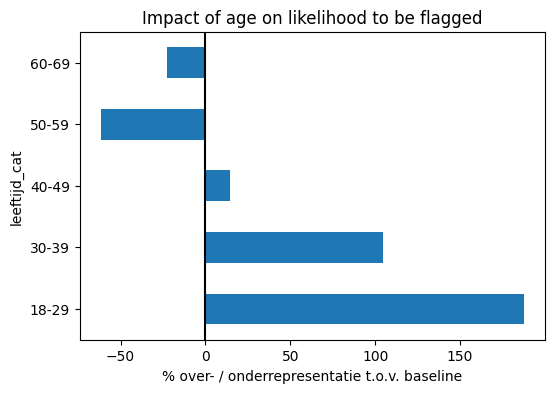

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# totale flag rate
overall_flag_rate = df_aif["binary_pred"].mean()

# flag rate per leeftijdsgroep
age_flag_rate = (
    df_aif.groupby("leeftijd_cat")["binary_pred"].mean()
)

# over-/onderrepresentatie (percentage verschil)
over_under = ((age_flag_rate - overall_flag_rate) / overall_flag_rate) * 100

print(over_under)

# plot
plt.figure(figsize=(6,4))
over_under.sort_index().plot(kind="barh")
plt.xlabel("% over- / onderrepresentatie t.o.v. baseline")
plt.title("Impact of age on likelihood to be flagged")
plt.axvline(0, color="black")
plt.show()


These results are very similar to those of Lighthouse, younger groups are overrepresented in the flagged group. This contrasts with the found SP metric. It shows that a metric like SP can mask differences. 

In [76]:
import pandas as pd

# flag rate per taaleis-groep
flag_rates = df_aif.groupby("contacten_onderwerp_boolean_taaleis___voldoet")["binary_pred"].mean()

flag_rates

RR = flag_rates[0] / flag_rates[1]   # 0 = niet voldoet, 1 = voldoet
print("Relative Risk:", RR)

Relative Risk: 1.1588858307250365


In [77]:

import pandas as pd

# flag rate per taaleis-groep
flag_rates = df_aif.groupby("persoon_geslacht_vrouw")["binary_pred"].mean()

flag_rates
RR = flag_rates[0] / flag_rates[1]   # 0 = niet voldoet, 1 = voldoet
print("Relative Risk:", RR)

Relative Risk: 1.0274243807709145


These metrics are the reverse of PPR: the risk of a negative score per group. I also see the increased risk as a result of the language requirement, but not for gender. 

So far we have oonly looked at SP but PPR/Disparate impact ratio might be a better metric, that expresses ratios instead of differences. 

# Disparate Impact Ratio

In [78]:
from aif360.sklearn.metrics import disparate_impact_ratio
import pandas as pd

def di_for_group(df, group_name):
    g = groups[group_name]
    
    # protected attribuut (bv. "contacten_onderwerp_boolean_taaleis___voldoet")
    attr = list(g["priv"][0].keys())[0]
    
    # privileged waarde (bv. 1) – unpriv wordt door AIF afgeleid
    priv_val = list(g["priv"][0].values())[0]
    
    di = disparate_impact_ratio(
        y_true=df["binary_pred"],              # wordt genegeerd als y_pred wordt meegegeven, maar is verplicht
        y_pred=df["binary_pred"],              # geflagged / model output
        prot_attr=df[attr],                    # kolom met protected attribuut
        priv_group=priv_val,                   # privileged value
        pos_label=0                            # 1 = negatieve beslising / risico
    )
    
    return di


In [79]:
di_results = []

for group_name in groups:
    di = di_for_group(df_aif, group_name)
    di_results.append({"group": group_name, "DI_ratio": di})

df_di = pd.DataFrame(di_results)
df_di


,group,DI_ratio
0,gender,1.003010
1,taaleis,0.984342
2,taaleis_schrijfv_ok,0.949207
3,nl_spreken1,1.005222
4,nl_spreken2,1.012573
5,nl_spreken3,0.952016
6,nl_lezen3,1.031132
7,nl_lezen4,0.987321
8,nl_schrijven0,0.980188
9,nl_schrijven1,1.028107


In [80]:
combined = df_sp.merge(df_di, on="group")
combined


,group,SP,DI_ratio
0,gender,0.002705,1.003010
1,taaleis,-0.014253,0.984342
2,taaleis_schrijfv_ok,-0.047027,0.949207
3,nl_spreken1,0.004680,1.005222
4,nl_spreken2,0.011232,1.012573
5,nl_spreken3,-0.045296,0.952016
6,nl_lezen3,0.027219,1.031132
7,nl_lezen4,-0.011555,0.987321
8,nl_schrijven0,-0.018072,0.980188
9,nl_schrijven1,0.024668,1.028107


# Interpretation
Disparate impact ratios (DI) were calculated for protected attributes, using the favorable outcome (“not flagged”) as the reference. Across all groups, DI values are very close to 1.0, indicating only small relative differences in the likelihood of receiving a favourable decision. This aligns with the statistical parity (SP) results reported earlier, but DI reflects these disparities on a relative rather than an absolute scale. For example, failing the language requirement (taaleis) results in a DI of 0.98, meaning that individuals who do not meet the requirement are about 2% less likely to avoid being flagged compared to those who do. This corresponds to the SP estimate of −0.014, a 1.4 percentage point difference. Similar patterns appear across most language-related variables, all showing mild disparities. The strongest disparity is observed for age: the “young” group (<50) shows a DI of 0.89, indicating that younger individuals are around 11% less likely to receive the favourable outcome than older individuals, consistent with the SP difference of −0.103. Overall, DI confirms the direction of disparities detected by SP, but expresses them as proportional rather than absolute differences. SP = –0.055 and DI = 0.94 indicate that individuals with financial problems receive the favourable outcome (not being flagged) less often than those without such problems. In other words, they are more likely to be flagged, with an approximately 6% lower chance of avoiding a risk classification.

# Conditional SP

Although conditional SP can be computed for this dataset, I have limited insight into what variables would be acceptable as an influential variable. Therefore I do not inlcude this metric here.

# Empirical Differential Fairness

We will now apply AIF's built in function to analyze fairness intersectionally. We will not use the dataset that we defined before, because there we defined many protected attributes. For EDF, it is important to carefully select relevant attributes to prevent that the value will explode as a result of small group sizes. Thus, we start by defining the protected attributes that we want to look into.

In [99]:
prot_cols = [
    "persoon_geslacht_vrouw",
    'typering_hist_inburgeringsbehoeftig',
    'adres_recentste_wijk_delfshaven'
    # "jong",
    # "contacten_onderwerp_boolean_taaleis___voldoet",
    # "belemmering_financiele_problemen"
]


In [100]:
from aif360.sklearn.metrics import smoothed_edf


edf = smoothed_edf(
    y_true=df_aif["binary_pred"],
    y_pred=None,  # mag je ook weglaten
    prot_attr=[df_aif[col] for col in prot_cols],
    pos_label=1,
    concentration=1.0
)

print("Smoothed EDF =", edf)

Smoothed EDF = 1.4116121691041807


The smoothed edf function only gives us the final edf value, so the largest edf for any pair of two groups. We are interested in the groups that lead to this result. Therefore, we use the following function that computes the same final value, but also shows the 'worst pairs':

In [102]:
import numpy as np
import pandas as pd

def smoothed_base_rates_df(df, label, protected, concentration=1.0):
    """
    Repliceert _smoothed_base_rates van AIF360,
    maar geeft een DataFrame terug met groepen + sbr.
    """
    # counts per (intersectie-)groep
    counts = (
        df.groupby(protected)[label]
          .agg(['sum', 'count'])
          .reset_index()
          .rename(columns={'sum': 'n_pos', 'count': 'n_total'})
    )

    K = df[label].nunique()  # meestal 2
    alpha = concentration / K

    counts["sbr"] = (counts["n_pos"] + alpha) / (counts["n_total"] + concentration)

    return counts  # bevat: protected cols, n_pos, n_total, sbr

def smoothed_edf_explainer(df, label, protected, concentration=1.0):
    # 1) smoothed base rates per groep
    groups = smoothed_base_rates_df(df, label, protected, concentration)

    rows = []
    for i, gi in groups.iterrows():
        for j, gj in groups.iterrows():
            if i == j:
                continue

            p_i = gi["sbr"]
            p_j = gj["sbr"]

            # pos_ratio en neg_ratio zoals in AIF360
            pos = abs(np.log(p_i) - np.log(p_j))
            neg = abs(np.log(1 - p_i) - np.log(1 - p_j))

            pair_edf = max(pos, neg)

            rows.append({
                "group_i": tuple(gi[p] for p in protected),
                "group_j": tuple(gj[p] for p in protected),
                "sbr_i": p_i,
                "sbr_j": p_j,
                "n_total_i": gi["n_total"],
                "n_pos_i": gi["n_pos"],
                "n_total_j": gj["n_total"],
                "n_pos_j": gj["n_pos"],
                "pos_ratio": pos,
                "neg_ratio": neg,
                "pair_edf": pair_edf,
            })

    pair_df = pd.DataFrame(rows)

    # 2) globale EDF = max over alle paren
    EDF = pair_df["pair_edf"].max()

    # 3) de paren die deze EDF veroorzaken
    worst_pairs = pair_df[pair_df["pair_edf"] == EDF]

    return EDF, groups, pair_df, worst_pairs



In [ ]:
EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=prot_cols,
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)


Globale EDF: 1.4116121691041807

Paren die de EDF bepalen:
            group_i          group_j     sbr_i     sbr_j  n_total_i  n_pos_i  \
48  (1.0, 1.0, 0.0)  (1.0, 1.0, 1.0)  0.046875  0.192308       31.0      1.0   
55  (1.0, 1.0, 1.0)  (1.0, 1.0, 0.0)  0.192308  0.046875       12.0      2.0   

    n_total_j  n_pos_j  pos_ratio  neg_ratio  pair_edf  
48       12.0      2.0   1.411612   0.165565  1.411612  
55       31.0      1.0   1.411612   0.165565  1.411612  


This verifies that the function computes the same EDF, and it prints the groups that cause this value. In this case, both groups represent women with a history of requiring civic integration. The groups differ in terms of neighbourhood. Women in this category who live in Delfshaven and those who live outside Delfshaven receive substantially different predicted outcomes, and this pairwise comparison forms the worst-case ratio that determines the overall EDF value. 

This means that Delfshaven becomes the decisive source of inequality when examined in combination with gender and civic integration history. 

This aligns with the purpose of differential fairness, which is designed to surface disparities that only become visible when multiple protected attributes interact, and to ensure that small or marginalized subgroups are not overlooked in fairness assessments.

However, we should be carfeul to interpret this. The worst-case EDF pair is driven by a very small subgroup, meaning that the observed disparity is statistically unstable.
The EDF value reflects sensitivity to individual cases rather than clear evidence of systematic differential treatment.
However, within the differential fairness framework this behavior is expected: small intersectional groups are not down-weighted, because their potential vulnerability is precisely what the framework aims to capture. Thus, EDF highlights a possible inequality, but not necessarily a robustly estimated one.

In the next cell, we include gender, children, language and financial problems as variables defining the intersectional groups.

In [ ]:
EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=['persoon_geslacht_vrouw',"relatie_kind_heeft_kinderen","contacten_onderwerp_boolean_taaleis___voldoet","belemmering_financiele_problemen"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)


Globale EDF: 1.1809078589952136

Paren die de EDF bepalen:
                  group_i               group_j     sbr_i     sbr_j  \
84   (0.0, 1.0, 0.0, 1.0)  (1.0, 0.0, 1.0, 0.0)  0.200246  0.061475   
155  (1.0, 0.0, 1.0, 0.0)  (0.0, 1.0, 0.0, 1.0)  0.061475  0.200246   

     n_total_i  n_pos_i  n_total_j  n_pos_j  pos_ratio  neg_ratio  pair_edf  
84       406.0     81.0      609.0     37.0   1.180908   0.160005  1.180908  
155      609.0     37.0      406.0     81.0   1.180908   0.160005  1.180908  


The largest disparity in predicted risk is between
men with children who do not meet the language requirement and experience financial problems (higher predicted risk)
and
women without children who meet the language requirement and do not experience financial problems (lower predicted risk).

This intersectional contrast drives the overall EDF value of 1.18.
The result indicates that the model treats these two intersectional profiles the most differently of all possible combinations of the protected attributes. 

In this case, the group sizes are much larger. 

Next, instead of including fianncial struggles, we now include mental problems.

In [ ]:
EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=['persoon_geslacht_vrouw',"relatie_kind_heeft_kinderen","contacten_onderwerp_boolean_taaleis___voldoet","belemmering_psychische_problemen"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)

Globale EDF: 1.0250759084133456

Paren die de EDF bepalen:
                  group_i               group_j     sbr_i     sbr_j  \
70   (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0, 1.0, 1.0)  0.167238  0.060000   
169  (1.0, 0.0, 1.0, 1.0)  (0.0, 1.0, 0.0, 0.0)  0.060000  0.167238   

     n_total_i  n_pos_i  n_total_j  n_pos_j  pos_ratio  neg_ratio  pair_edf  
70       582.0     97.0      424.0     25.0   1.025076   0.121132  1.025076  
169      424.0     25.0      582.0     97.0   1.025076   0.121132  1.025076  


The model predicts a substantially higher risk score for men with children who do not meet the language requirement and have no psychological problems compared to women without children who meet the language requirement but do experience psychological problems. This is a similar result as in the previous case, where we looked at financial struggles instead of mental struggles.

Now I investigate what happens when we exclude the financial/mental struggles.

In [ ]:
EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=['persoon_geslacht_vrouw',"relatie_kind_heeft_kinderen","contacten_onderwerp_boolean_taaleis___voldoet"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)

Globale EDF: 0.9399680679544311

Paren die de EDF bepalen:
            group_i          group_j     sbr_i     sbr_j  n_total_i  n_pos_i  \
18  (0.0, 1.0, 0.0)  (1.0, 0.0, 1.0)  0.163942  0.064042     1100.0    180.0   
37  (1.0, 0.0, 1.0)  (0.0, 1.0, 0.0)  0.064042  0.163942      850.0     54.0   

    n_total_j  n_pos_j  pos_ratio  neg_ratio  pair_edf  
18      850.0     54.0   0.939968   0.112872  0.939968  
37     1100.0    180.0   0.939968   0.112872  0.939968  


Removing the financial and psychological variables did not change the structure of the observed disparities. The worst-case EDF pair is again formed by men with children who do not meet the language requirement versus women without children who do meet the language requirement.

# TO DO: Maybe this makes more sense after the analysis of the lighthouse archetypes, to experiment with different variables.

# Archetypes

In their anaysis, Lighthouse Reports constructed several archetypes. They based these archetypes on interviews. I will compute EDF values by incuding the variables that cosntruct the archetypes. 

## Fincancially struggling single mother
"We made her a woman, a mother of two children, who had been in a long term relationship, and has been struggling financially"

This is how they defined the archetype:

variable_list = [[{"persoon_geslacht_vrouw":["ALL"]}], [{"relatie_partner_totaal_dagen_partner":["0", "720"]}], [{"relatie_kind_huidige_aantal":["0", "2"]}], 
#[{"relatie_kind_heeft_kinderen":["ALL"]}],[{"relatie_kind_leeftijd_verschil_ouder_eerste_kind":["0", "20"]}], [{"relatie_kind_basisschool_kind":["0", "2"]}],
[{"belemmering_dagen_financiele_problemen":["0","700"]}]]

To be able to analyze some of these categorical variables in a similar way, we now first transform some of these into categorical variables. 


In [111]:
import numpy as np

bins = [-np.inf, 0, 699, np.inf]
labels = ["0", "<700", "700+"]
df_aif["fin_cat"] = pd.cut(
    df_aif["belemmering_dagen_financiele_problemen"],
    bins=bins,
    labels=labels,
    right=True
)

bins = [-np.inf,  359, 719, np.inf]
labels = ["<360", "<720", "720+"]
df_aif["partner_cat"] = pd.cut(
    df_aif["relatie_partner_totaal_dagen_partner"],
    bins=bins,
    labels=labels,
    right=True
)


df_aif["basisschool_cat"] = np.where(
    df_aif["relatie_kind_basisschool_kind"] == 0,
    "0",
    "1+"
)


df_aif["kind_cat"] = np.where(
    df_aif["relatie_kind_huidige_aantal"] == 0,
    "0",
    "1+"
)

df_aif["rel_kind_age_gap_cat"] = df_aif["relatie_kind_leeftijd_verschil_ouder_eerste_kind"].astype(float)
df_aif["rel_kind_age_gap_cat"] = pd.cut(
    df_aif["rel_kind_age_gap_cat"],
    bins=[-float("inf"), 3, float("inf")],
    labels=["≤3", ">3"]
)





C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\2849200183.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aif["fin_cat"] = pd.cut(
C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\2849200183.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aif["partner_cat"] = pd.cut(
C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\2849200183.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 


Now we define the financially struggling single mother archetype. I do not include all variables, because this might lead to logical inconsistencies. 

In [ ]:
EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=['persoon_geslacht_vrouw',"partner_cat", "basisschool_cat","fin_cat"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)

C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\1672653076.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(protected)[label]


Globale EDF: 2.1362462407067007

Paren die de EDF bepalen:
                 group_i              group_j     sbr_i     sbr_j  n_total_i  \
199  (0, <360, 1+, 700+)   (1, <720, 0, <700)  0.215278  0.025424         71   
880   (1, <720, 0, <700)  (0, <360, 1+, 700+)  0.025424  0.215278         58   

     n_pos_i  n_total_j  n_pos_j  pos_ratio  neg_ratio  pair_edf  
199       15         58        1   2.136246   0.216673  2.136246  
880        1         71       15   2.136246   0.216673  2.136246  


When I test for the variables used in the single-mother archetype, I find a pattern that differs from Lighthouse’s findings. Lighthouse reported that single mothers with two children in primary school and financial struggles were disproportionately discriminated against. Interestingly, our results show something else: the largest discrepancy appears between men with fewer than 360 partner days, with children in primary school, and more than 700 days of financial struggles, compared to women with fewer than 360 partner days, without children and with less than 700 days of financial struggles. The first group is treated significantly worse.

In [ ]:
EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=['persoon_geslacht_vrouw', "basisschool_cat","fin_cat"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)

Globale EDF: 1.1473114091284653

Paren die de EDF bepalen:
          group_i        group_j     sbr_i     sbr_j  n_total_i  n_pos_i  \
61  (0, 1+, 700+)   (1, 0, <700)  0.191338  0.060748        911      174   
82   (1, 0, <700)  (0, 1+, 700+)  0.060748  0.191338        320       19   

    n_total_j  n_pos_j  pos_ratio  neg_ratio  pair_edf  
61        320       19   1.147311   0.149703  1.147311  
82        911      174   1.147311   0.149703  1.147311  


C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\1672653076.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(protected)[label]


Removing the partner variable, we observe the same underlying pattern. Although the EDF value decreases, the groups that determine the disparity become much larger, suggesting that this is not an artefact of small or unstable subgroups but may reflect a structural inequality in the data. Even without partner stability as a predictor, financially unstable men with children in primary school are still treated substantially worse than comparatively stable women without children. 

# To do: add mother + language

## Migrant worker

The next archetype defined by Lighthouse is that of a migrant worker. They define this in different ways. One of the ways they control for migration background is looking at whether someone lives in Delfshaven. According to statistics from the city, nearly 70% of Delfshaven residents have a migrant background. In addition, they state that many migrant workers live with roommates. Specifically, they look at the group of people living with three roommates.

Hence, they define this archetype as follows:

 variable_list = [[{"relatie_overig_historie_vorm__andere_inwonende":["0","3"]}],[{"adres_recentste_wijk_delfshaven":["ALL"]}, 
{"adres_recentste_wijk_stadscentru":[“ALL”]}],[{"adres_recentste_wijk_charlois":[“0”]}], [{"adres_recentste_wijk_feijenoord":[“0”]}], 
 [{"adres_recentste_wijk_ijsselmonde":[“0”]}], [{"adres_recentste_wijk_kralingen_c":[“0”]}], [{"adres_recentste_wijk_noord":[“0”]}],
  [{"adres_recentste_wijk_other":[“0”]}], [{"adres_recentste_wijk_prins_alexa":[“0”]}], [{"adres_recentste_buurt_nieuwe_westen":["0"]}], 
 [{"adres_recentste_buurt_other":[“1”]}], [{"adres_recentste_buurt_groot_ijsselmonde":[“0”]}], [{"adres_recentste_buurt_oude_noorden":[“0”]}],
  [{"adres_recentste_buurt_vreewijk":[“0”]}], [{"adres_recentst_onderdeel_rdam":[“1”]}], [{"adres_recentste_plaats_rotterdam":[“1”]}],
  [{"adres_recentste_plaats_other":[“0”]}]]




In [118]:
df_aif["relatie_overig_historie_vorm__andere_inwonende"].value_counts(dropna=False)


relatie_overig_historie_vorm__andere_inwonende
1    6019
0    5959
2     652
3      15
Name: count, dtype: int64

Inspecting the synthetic data, we find only 15 people who live with 3 roommates. 

In [ ]:
EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=["relatie_overig_historie_vorm__andere_inwonende","adres_recentste_wijk_delfshaven"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)

Globale EDF: 1.4605861033926117

Paren die de EDF bepalen:
       group_i     group_j    sbr_i    sbr_j  n_total_i  n_pos_i  n_total_j  \
6   (0.0, 0.0)  (3.0, 1.0)  0.06963  0.30000     5162.0    359.0        4.0   
49  (3.0, 1.0)  (0.0, 0.0)  0.30000  0.06963        4.0      1.0     5162.0   

    n_pos_j  pos_ratio  neg_ratio  pair_edf  
6       1.0   1.460586   0.284502  1.460586  
49    359.0   1.460586   0.284502  1.460586  


This gives us the insight that there are only 4 cases in the dataset of people living in Delfshaven who have 3 roommates. Although EDF is specifically meant to detect small groups, this result is very unstable and unreliable. Therefore, I will transform the variable indicating the number of roommates to less than 2 and 2 or more. 

In [121]:
df_aif["roommates_cat"] = np.where(
    df_aif["relatie_overig_historie_vorm__andere_inwonende"] <= 1,
    "<2",
    "2+"
)

df_aif["roommates_cat"].value_counts(dropna=False)

C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\3286512971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aif["roommates_cat"] = np.where(


roommates_cat
<2    11978
2+      667
Name: count, dtype: int64

In [135]:
EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=["roommates_cat","adres_recentste_wijk_delfshaven"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)

Global EDF: 0.6837993209474584

Worst pairs:
   group_i  group_j     sbr_i     sbr_j  n_total_i  n_pos_i  n_total_j  \
4  (2+, 1)  (<2, 0)  0.190217  0.096002         91       17      10379   
7  (<2, 0)  (2+, 1)  0.096002  0.190217      10379      996         91   

   n_pos_j  pos_ratio  neg_ratio  pair_edf  
4      996   0.683799   0.110061  0.683799  
7       17   0.683799   0.110061  0.683799  


The EDF analysis for roommates and residence in Delfshaven shows a moderate disparity. Individuals living in Delfshaven with two or more roommates have nearly twice the risk score of those living outside Delfshaven with fewer than two roommates (19% vs. 9.6%), resulting in an EDF of 0.68. The subgroup living in Delfshaven with multiple roommates is relatively small (n = 91), hence the result should be interpreted with caution given the imbalance in group sizes.

Next, they include the language requirement and days since the language requirement in this archetype. Therefore we first transform the days since language requirement variable.

In [130]:
bins = [-np.inf,  0, 719, np.inf]
labels = ["0", "<720", "720+"]
df_aif["dagen_taaleis_cat"] = pd.cut(
    df_aif["persoonlijke_eigenschappen_dagen_sinds_taaleis"],
    bins=bins,
    labels=labels,
    right=True)

df_aif["dagen_taaleis_cat"].value_counts(dropna=False)

C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\3643534099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aif["dagen_taaleis_cat"] = pd.cut(


dagen_taaleis_cat
<720    10429
720+     2210
0           6
Name: count, dtype: int64

It is very strange that there are only 6 values of 0, since these are the people that never had to meet the language requirement. We investigate the distribution.

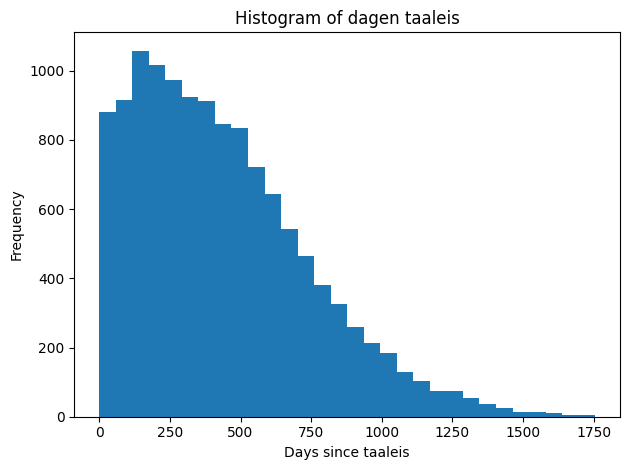

In [129]:
import matplotlib.pyplot as plt

plt.hist(df_aif["persoonlijke_eigenschappen_dagen_sinds_taaleis"].dropna(), bins=30)

plt.title("Histogram of dagen taaleis")
plt.xlabel("Days since taaleis")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


There are many low values, but not many 0s. Maybe this went wrong in the creation of the synthetic data. We can still investigate how the model treats differences in days since the language requirement. 

In [133]:
df_aif["dagen_taaleis_cat"] = np.where(
    df_aif["persoonlijke_eigenschappen_dagen_sinds_taaleis"] <= 719,
    "<720",
    "720+"
)

df_aif["dagen_taaleis_cat"].value_counts(dropna=False)

C:\Users\jetve\AppData\Local\Temp\ipykernel_27568\1245443983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aif["dagen_taaleis_cat"] = np.where(


dagen_taaleis_cat
<720    10435
720+     2210
Name: count, dtype: int64

In [136]:

EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=["dagen_taaleis_cat", "contacten_onderwerp_boolean_taaleis___voldoet","adres_recentste_wijk_delfshaven"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)

Global EDF: 1.7153198748487455

Worst pairs:
         group_i       group_j     sbr_i     sbr_j  n_total_i  n_pos_i  \
4   (720+, 0, 0)  (<720, 0, 1)  0.024349  0.135342        882       21   
35  (<720, 0, 1)  (720+, 0, 0)  0.135342  0.024349       1111      150   

    n_total_j  n_pos_j  pos_ratio  neg_ratio  pair_edf  
4        1111      150    1.71532   0.120771   1.71532  
35        882       21    1.71532   0.120771   1.71532  


The strongest disparity occurs between individuals who have been under the language requirement for less than 720 days, have not met the requirement, and live in Delfshaven, versus those who have been under the requirement for more than 720 days, have not met it, and live outside Delfshaven. The former group is assigned a high-risk label more than five times as often (13.5% vs. 2.4%).

Since there are some problems with the 'days since language requirement variable', I now exclude this variable. 

In [ ]:

EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=["adres_recentste_wijk_delfshaven","contacten_onderwerp_boolean_taaleis___voldoet"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)

Global EDF: 0.37013033861369804

Worst pairs:
       group_i     group_j     sbr_i     sbr_j  n_total_i  n_pos_i  n_total_j  \
5   (0.0, 1.0)  (1.0, 1.0)  0.123403  0.085227     1251.0    154.0      439.0   
10  (1.0, 1.0)  (0.0, 1.0)  0.085227  0.123403      439.0     37.0     1251.0   

    n_pos_j  pos_ratio  neg_ratio  pair_edf  
5      37.0    0.37013   0.042628   0.37013  
10    154.0    0.37013   0.042628   0.37013  


This leads to a very different result: for people who do meet the language requirements, those living outside of Delfshaven generally receive higher risk scores. 

Now I look at some other variables that indicate Dutch language proficiency. 

In [138]:

EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=["adres_recentste_wijk_delfshaven","persoonlijke_eigenschappen_taaleis_schrijfv_ok"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)

Global EDF: 0.6242054948920592

Worst pairs:
      group_i     group_j     sbr_i     sbr_j  n_total_i  n_pos_i  n_total_j  \
4  (0.0, 1.0)  (1.0, 0.0)  0.073198  0.136643     4965.0    363.0      976.0   
7  (1.0, 0.0)  (0.0, 1.0)  0.136643  0.073198      976.0    133.0     4965.0   

   n_pos_j  pos_ratio  neg_ratio  pair_edf  
4    133.0   0.624205   0.070912  0.624205  
7    363.0   0.624205   0.070912  0.624205  


The largest disparity appears between individuals living in Delfshaven with insufficient written language skills and those living outside Delfshaven who have sufficient skills. The former group receives high-risk labels nearly twice as often (13.7% vs. 7.3%), resulting in an EDF of 0.62. This suggests a moderate intersectional inequality in which limited language proficiency interacts with neighbourhood vulnerability, although the magnitude is substantially smaller than in earlier taaleis-related analyses.

# TO DO am i missing any important intersectional variables?

# The Bad Dutch Archetype

Lighthouse defines an archetype combining many language characteristics, representing people with bad Dutch skills. This is defined as follows:

variable_list = [[{"persoonlijke_eigenschappen_spreektaal":["0","4"]}],[{"persoonlijke_eigenschappen_taaleis_voldaan":["0"]}],[{"persoonlijke_eigenschappen_dagen_sinds_taaleis":["0"]}], [{"afspraak_afgelopen_jaar_ontheffing_taaleis":["0"]}], [{"contacten_onderwerp_beoordelen_taaleis":["0"]}],[{"afspraak_verzenden_beschikking_i_v_m__niet_voldoen_aan_wet_taaleis":["1"]}],[{"persoonlijke_eigenschappen_taaleis_schrijfv_ok":["0"]}],[{"persoonlijke_eigenschappen_spreektaal_anders":["1"]}],[{"contacten_onderwerp_boolean_beoordelen_taaleis":["0"]}],[{"contacten_onderwerp_boolean_taaleis___voldoet":["0"]}],[{"belemmering_hist_taal":["1"]}],[{"persoonlijke_eigenschappen_nl_spreken1":["1"]}], [{"persoonlijke_eigenschappen_nl_spreken2":["0"]}], [{"persoonlijke_eigenschappen_nl_spreken3":["0"]}],[{"persoonlijke_eigenschappen_nl_begrijpen3":["0"]}],[{"persoonlijke_eigenschappen_nl_schrijven0":["0"]}], [{"persoonlijke_eigenschappen_nl_schrijven1":["0"]}], [{"persoonlijke_eigenschappen_nl_schrijven2":["0"]}], [{"persoonlijke_eigenschappen_nl_schrijven3":["0"]}],[{"persoonlijke_eigenschappen_nl_schrijvenfalse":["0"]}],[{"persoonlijke_eigenschappen_nl_lezen3":["0"]}], [{"persoonlijke_eigenschappen_nl_lezen4":["0"]}]]


I select some of these variables to construct a similar archetype.

In [ ]:
EDF, groups, pair_df, worst_pairs = smoothed_edf_explainer(
    df_aif,
    label="binary_pred",
    protected=["contacten_onderwerp_boolean_taaleis___voldoet",
               "dagen_taaleis_cat",
               "persoonlijke_eigenschappen_taaleis_schrijfv_ok",
               "belemmering_hist_taal"],
    concentration=1.0
)

print("Global EDF:", EDF)
print("\nWorst pairs:")
print(worst_pairs)

Global EDF: 2.031997453901565

Worst pairs:
             group_i          group_j   sbr_i   sbr_j  n_total_i  n_pos_i  \
41   (0, 720+, 1, 0)  (1, <720, 0, 0)  0.0232  0.1770        624       14   
182  (1, <720, 0, 0)  (0, 720+, 1, 0)  0.1770  0.0232        499       88   

     n_total_j  n_pos_j  pos_ratio  neg_ratio  pair_edf  
41         499       88   2.031997   0.171326  2.031997  
182        624       14   2.031997   0.171326  2.031997  


The worst EDF pair arises because the model assigns low risk to individuals who do not meet the taaleis requirement but have long taaleis duration (720+ days) and OK writing skills, while it assigns much higher risk to individuals who meet the taaleis requirement but have shorter taaleis duration (<720 days) and not-OK writing skills.

# to do exclude taaleis? onduidelijk te interpreteren?
excluded_combinations = [{"persoonlijke_eigenschappen_taaleis_voldaan":"0","persoonlijke_eigenschappen_dagen_sinds_taaleis":"720"}, {"persoonlijke_eigenschappen_taaleis_voldaan":"1", "persoonlijke_eigenschappen_dagen_sinds_taaleis":"0"}]
 
 dus niet voldaan > dagen hoog
 wel voldaan > dagen 0.

# Statistical parity difference, one vs. rest   

AIF360 also provides functions to compute statistical parity for intersectional groups. The one_vs_rest function takes a fairness metric and a set of protected attributes, and for each intersectional group defined by those attributes, it computes the statistical parity difference (SPD) between that group and the rest of the dataset. In other words, for every possible intersectional subgroup, it evaluates how their predicted outcomes differ compared to all individuals not in the group. This makes it a useful complementary tool for interpreting and comparing some of the fairness patterns I observed with EDF.

In [ ]:
from aif360.sklearn.metrics import (
    statistical_parity_difference,
    one_vs_rest,
)

prot = [
    "persoon_geslacht_vrouw",
    "kind_cat",
    "contacten_onderwerp_boolean_taaleis___voldoet",
    #"adres_recentste_wijk_delfshaven",
    "persoonlijke_eigenschappen_taaleis_schrijfv_ok"
]

# y: labels met protected attrs in de index
y = df_aif.set_index(prot)["binary_pred"]

vals, groups = one_vs_rest(
    func=statistical_parity_difference,
    y_true=y,
    prot_attr=prot,
    return_groups=True,
    pos_label=0,
)

sp_intersection = pd.DataFrame({
    "group": groups,
    "spd": vals,
})


sp_intersection[prot] = pd.DataFrame(
    sp_intersection["group"].tolist(),
    index=sp_intersection.index
)


sp_intersection = sp_intersection.drop(columns="group")

group_sizes = (
    df_aif
    .groupby(prot)
    .size()
    .reset_index(name="group_size")
)

sp_intersection = sp_intersection.merge(group_sizes, on=prot, how="left")

# sorteren op grootste negatieve SPD
sp_intersection = sp_intersection.reindex(
    sp_intersection["spd"].sort_values(ascending=True).index
)

print(sp_intersection.head(10))


         spd  persoon_geslacht_vrouw kind_cat  \
11 -0.080794                       1        0   
1  -0.058039                       0        0   
9  -0.053801                       1        0   
3  -0.053078                       0        0   
0  -0.048106                       0        0   
8  -0.029822                       1        0   
13 -0.029006                       1       1+   
2  -0.021708                       0        0   
15 -0.020208                       1       1+   
7   0.008297                       0       1+   

    contacten_onderwerp_boolean_taaleis___voldoet  \
11                                              1   
1                                               0   
9                                               0   
3                                               1   
0                                               0   
8                                               0   
13                                              0   
2                                   

# Disparate impact ratio, one vs rest

In [156]:
from aif360.sklearn.metrics import (
    disparate_impact_ratio,
    one_vs_rest,
)

prot = [
    "persoon_geslacht_vrouw",
    "kind_cat",
    #"contacten_onderwerp_boolean_taaleis___voldoet",
    #"adres_recentste_wijk_delfshaven",
    "persoonlijke_eigenschappen_taaleis_schrijfv_ok"
]

# y: labels met protected attrs in de index
y = df_aif.set_index(prot)["binary_pred"]

vals, groups = one_vs_rest(
    func=disparate_impact_ratio,
    y_true=y,
    prot_attr=prot,
    return_groups=True,
    pos_label=0,
)

sp_intersection = pd.DataFrame({
    "group": groups,
    "DIR": vals,
})


sp_intersection[prot] = pd.DataFrame(
    sp_intersection["group"].tolist(),
    index=sp_intersection.index
)


sp_intersection = sp_intersection.drop(columns="group")

group_sizes = (
    df_aif
    .groupby(prot)
    .size()
    .reset_index(name="group_size")
)

sp_intersection = sp_intersection.merge(group_sizes, on=prot, how="left")

# sorteren op grootste negatieve SPD
sp_intersection = sp_intersection.reindex(
    sp_intersection["DIR"].sort_values(ascending=True).index
)

print(sp_intersection.head(10))


        DIR  persoon_geslacht_vrouw kind_cat  \
5  0.928837                       1        0   
1  0.938412                       0        0   
0  0.950244                       0        0   
7  0.970573                       1       1+   
4  0.976088                       1        0   
3  1.010883                       0       1+   
6  1.060456                       1       1+   
2  1.092133                       0       1+   

   persoonlijke_eigenschappen_taaleis_schrijfv_ok  group_size  
5                                               1         684  
1                                               1        1251  
0                                               0        1727  
7                                               1        2215  
4                                               0         781  
3                                               1        1529  
6                                               0        2423  
2                                               0      

# Interpretation
